<h1> Objective:- Assessment Task 4.3P: Build your own image recognition system – group task </h1>

<div style="text-align: right"> Done by: <b>Karan Murjani and Prateek Singh </b> </div>
<div style="text-align: right"> StudentId: <b> 221047083 </b></div>
<div style="text-align: right"> StudentId: <b> 221218743 </b></div>

### Building image recognition application

### 2.1. Bag-of-Words (BoW) model

In [1]:
#Importing all library
import pandas as pd
import numpy as np
import cv2 as cv
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
import os
import pickle
import matplotlib.pyplot as plt
from matplotlib.image import imread

from yellowbrick.cluster import InterclusterDistance
#os.chdir('/Users/karanmurjani/Downloads/Study/Trimester 2 - SY/Computer Vision & NLP/Resource_4.3/')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
#Defining class

class Dictionary(object):
    def __init__(self, name, img_filenames, num_words):
        self.name = name #name of your dictionary
        self.img_filenames = img_filenames #list of image filenames
        self.num_words = num_words #the number of words

        self.training_data = [] #this is the training data required by the K-Means algorithm
        self.words = [] #list of words, which are the centroids of clusters

    def learn(self):
        sift = cv.SIFT_create()
        num_keypoints = [] #this is used to store the number of keypoints in each image

     #load training images and compute SIFT descriptors
        for filename in self.img_filenames:
            img = cv.imread(filename)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            list_des = sift.detectAndCompute(img_gray, None)[1]
            if list_des is None:
                num_keypoints.append(0)
            else:
                num_keypoints.append(len(list_des))
                for des in list_des:
                    self.training_data.append(des)

        #cluster SIFT descriptors using K-means algorithm
        kmeans = KMeans(self.num_words)
        kmeans.fit(self.training_data)
        self.words = kmeans.cluster_centers_

        #create word histograms for training images
        training_word_histograms = [] #list of word histograms of all training images
        index = 0
        for i in range(0, len(self.img_filenames)):
            #for each file, create a histogram
            histogram = np.zeros(self.num_words, np.float32)
            #if some keypoints exist
            if num_keypoints[i] > 0:
                for j in range(0, num_keypoints[i]):
                    histogram[kmeans.labels_[j + index]] += 1
                index += num_keypoints[i]
                histogram /= num_keypoints[i]
                training_word_histograms.append(histogram)

        return training_word_histograms

    def create_word_histograms(self, img_filenames):
        sift = cv.SIFT_create()
        histograms = []

        for filename in img_filenames:
            img = cv.imread(filename)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            descriptors = sift.detectAndCompute(img_gray, None)[1]

            histogram = np.zeros(self.num_words, np.float32) #word histogram for the input image

            if descriptors is not None:
                for des in descriptors:
                #find the best matching word
                    min_distance = 1111111 #this can be any large number
                    matching_word_ID = -1 #initial matching_word_ID=-1 means no matching

                    for i in range(0, self.num_words): #search for the best matching word
                        distance = np.linalg.norm(des - self.words[i])
                        if distance < min_distance:
                            min_distance = distance
                            matching_word_ID = i

                    histogram[matching_word_ID] += 1

                histogram /= len(descriptors) #normalise histogram to frequencies

            histograms.append(histogram)

        return histograms

In [3]:
#Preparing training data
fruits = ['apple_granny_smith_1', 'apple_pink_lady_1', 'carrot_1', 'eggplant_violet_1', 'zucchini_1']
path = 'Fruit_Dataset/'
training_file_names = []
training_fruit_labels = []

for i in range(0, len(fruits)):
    sub_path = path + 'Training/' + fruits[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_fruit_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    training_file_names += sub_file_names
    training_fruit_labels += sub_fruit_labels

print(training_file_names)
print(training_fruit_labels)

['Fruit_Dataset/Training/apple_granny_smith_1/r0_0.jpg', 'Fruit_Dataset/Training/apple_granny_smith_1/r0_10.jpg', 'Fruit_Dataset/Training/apple_granny_smith_1/r0_100.jpg', 'Fruit_Dataset/Training/apple_granny_smith_1/r0_102.jpg', 'Fruit_Dataset/Training/apple_granny_smith_1/r0_104.jpg', 'Fruit_Dataset/Training/apple_granny_smith_1/r0_106.jpg', 'Fruit_Dataset/Training/apple_granny_smith_1/r0_108.jpg', 'Fruit_Dataset/Training/apple_granny_smith_1/r0_110.jpg', 'Fruit_Dataset/Training/apple_granny_smith_1/r0_112.jpg', 'Fruit_Dataset/Training/apple_granny_smith_1/r0_114.jpg', 'Fruit_Dataset/Training/apple_granny_smith_1/r0_116.jpg', 'Fruit_Dataset/Training/apple_granny_smith_1/r0_118.jpg', 'Fruit_Dataset/Training/apple_granny_smith_1/r0_12.jpg', 'Fruit_Dataset/Training/apple_granny_smith_1/r0_120.jpg', 'Fruit_Dataset/Training/apple_granny_smith_1/r0_122.jpg', 'Fruit_Dataset/Training/apple_granny_smith_1/r0_124.jpg', 'Fruit_Dataset/Training/apple_granny_smith_1/r0_126.jpg', 'Fruit_Dataset/Tr

In [4]:
#Preparing validation data
path = './Fruit_Dataset/'
validation_file_names = []
validation_fruit_labels = []

for i in range(0, len(fruits)):
    sub_path = path + 'Validation/' + fruits[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_fruit_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    validation_file_names += sub_file_names
    validation_fruit_labels += sub_fruit_labels

print(validation_file_names)
print(validation_fruit_labels)

['./Fruit_Dataset/Validation/apple_granny_smith_1/r0_1.jpg', './Fruit_Dataset/Validation/apple_granny_smith_1/r0_101.jpg', './Fruit_Dataset/Validation/apple_granny_smith_1/r0_105.jpg', './Fruit_Dataset/Validation/apple_granny_smith_1/r0_109.jpg', './Fruit_Dataset/Validation/apple_granny_smith_1/r0_113.jpg', './Fruit_Dataset/Validation/apple_granny_smith_1/r0_117.jpg', './Fruit_Dataset/Validation/apple_granny_smith_1/r0_121.jpg', './Fruit_Dataset/Validation/apple_granny_smith_1/r0_125.jpg', './Fruit_Dataset/Validation/apple_granny_smith_1/r0_129.jpg', './Fruit_Dataset/Validation/apple_granny_smith_1/r0_13.jpg', './Fruit_Dataset/Validation/apple_granny_smith_1/r0_133.jpg', './Fruit_Dataset/Validation/apple_granny_smith_1/r0_137.jpg', './Fruit_Dataset/Validation/apple_granny_smith_1/r0_141.jpg', './Fruit_Dataset/Validation/apple_granny_smith_1/r0_145.jpg', './Fruit_Dataset/Validation/apple_granny_smith_1/r0_149.jpg', './Fruit_Dataset/Validation/apple_granny_smith_1/r0_153.jpg', './Fruit_D

In [5]:
#Preparing testing data
testing_file_names = []
testing_fruit_labels = []

for i in range(0, len(fruits)):
    sub_path = path + 'Test/' + fruits[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    
    sub_fruit_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    
    testing_file_names += sub_file_names
    testing_fruit_labels += sub_fruit_labels

print(testing_file_names)
print(testing_fruit_labels)

['./Fruit_Dataset/Test/apple_granny_smith_1/r0_103.jpg', './Fruit_Dataset/Test/apple_granny_smith_1/r0_107.jpg', './Fruit_Dataset/Test/apple_granny_smith_1/r0_11.jpg', './Fruit_Dataset/Test/apple_granny_smith_1/r0_111.jpg', './Fruit_Dataset/Test/apple_granny_smith_1/r0_115.jpg', './Fruit_Dataset/Test/apple_granny_smith_1/r0_119.jpg', './Fruit_Dataset/Test/apple_granny_smith_1/r0_123.jpg', './Fruit_Dataset/Test/apple_granny_smith_1/r0_127.jpg', './Fruit_Dataset/Test/apple_granny_smith_1/r0_131.jpg', './Fruit_Dataset/Test/apple_granny_smith_1/r0_135.jpg', './Fruit_Dataset/Test/apple_granny_smith_1/r0_139.jpg', './Fruit_Dataset/Test/apple_granny_smith_1/r0_143.jpg', './Fruit_Dataset/Test/apple_granny_smith_1/r0_147.jpg', './Fruit_Dataset/Test/apple_granny_smith_1/r0_15.jpg', './Fruit_Dataset/Test/apple_granny_smith_1/r0_151.jpg', './Fruit_Dataset/Test/apple_granny_smith_1/r0_155.jpg', './Fruit_Dataset/Test/apple_granny_smith_1/r0_159.jpg', './Fruit_Dataset/Test/apple_granny_smith_1/r0_163

In [6]:
training_data = []
sift = cv.SIFT_create()
num_keypoints = []

#load training images and compute SIFT descriptors
for filename in training_file_names:
    img = cv.imread(filename)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    list_des = sift.detectAndCompute(img_gray, None)[1]
    if list_des is None:
        num_keypoints.append(0)
    else:
        num_keypoints.append(len(list_des))
        for des in list_des:
            training_data.append(des)

In [7]:
#Elbow method
sse = []
init_k = [2, 3, 4, 5, 10, 15, 20]
list_k = init_k + list(range(50, 600, 100))
print (list_k)
#for k in list_k:
#    km = KMeans(n_clusters=k, random_state=123)
#    km.fit(training_data)
#    sse.append(km.inertia_)
#
## Plot sse against k
#plt.figure(figsize=(6, 6))
#plt.plot(list_k, sse, '-o')
#plt.xlabel(r'Number of clusters *k*')
#plt.ylabel('Sum of squared distance')

[2, 3, 4, 5, 10, 15, 20, 50, 150, 250, 350, 450, 550]


For n_clusters = 2 The average silhouette_score is : 0.40110365
For n_clusters = 3 The average silhouette_score is : 0.18661715
For n_clusters = 4 The average silhouette_score is : 0.19666304
For n_clusters = 5 The average silhouette_score is : 0.21199824
For n_clusters = 10 The average silhouette_score is : 0.22515723
For n_clusters = 15 The average silhouette_score is : 0.21174245
For n_clusters = 20 The average silhouette_score is : 0.13618326
For n_clusters = 50 The average silhouette_score is : 0.09280199
For n_clusters = 150 The average silhouette_score is : 0.085380495
For n_clusters = 250 The average silhouette_score is : 0.08256845
For n_clusters = 350 The average silhouette_score is : 0.08406744
For n_clusters = 450 The average silhouette_score is : 0.08637937
For n_clusters = 550 The average silhouette_score is : 0.08801104


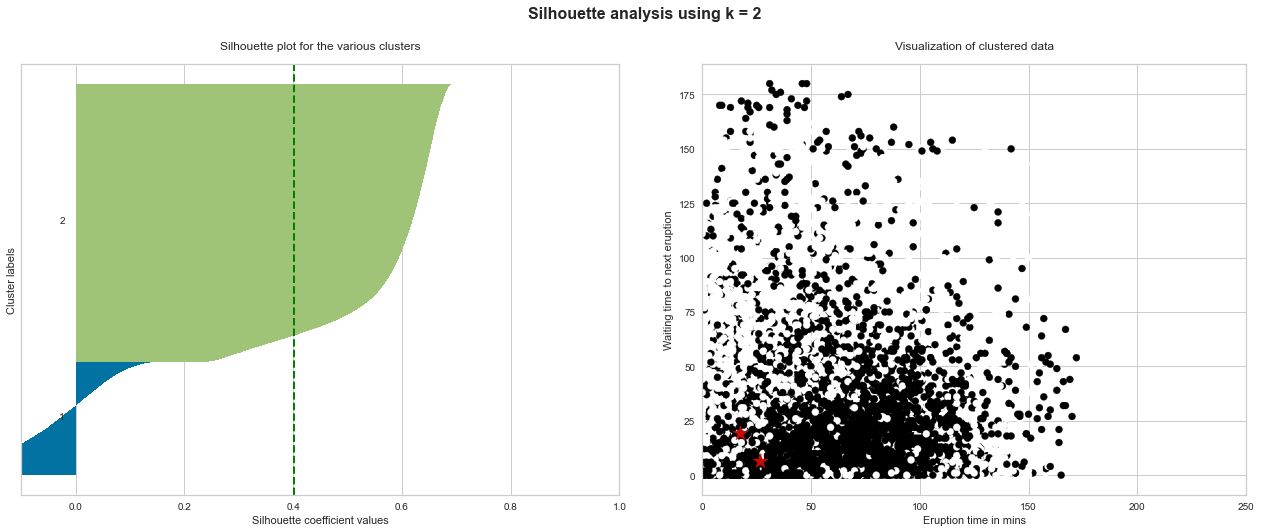

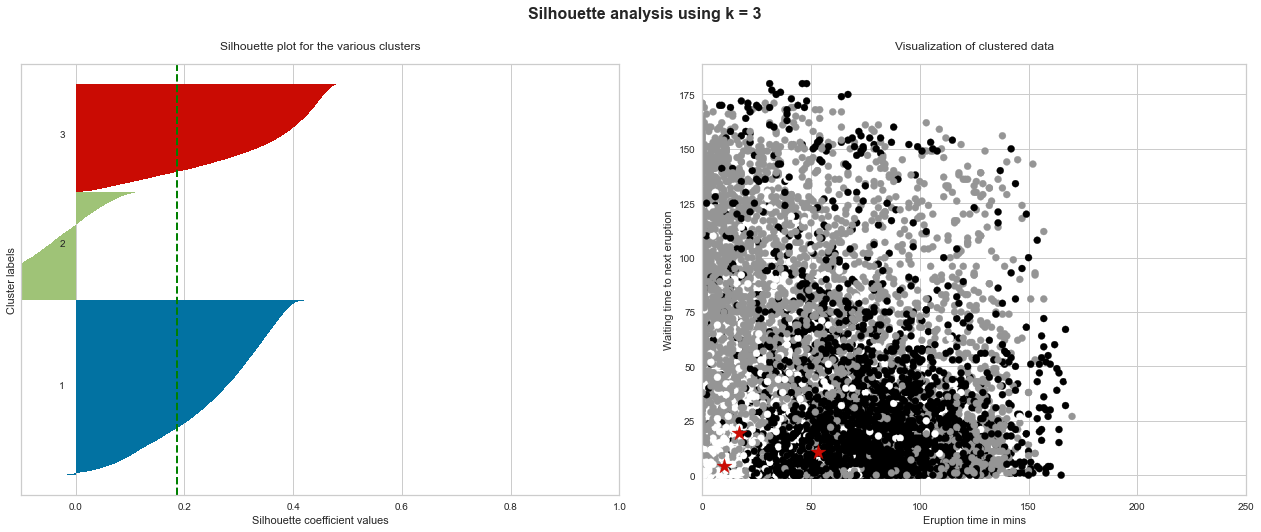

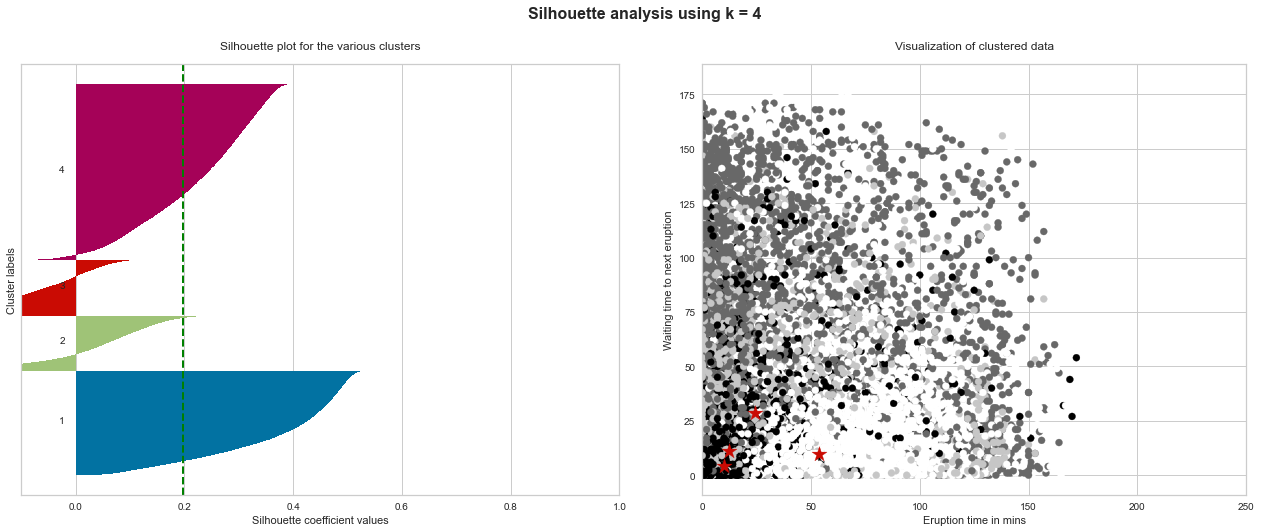

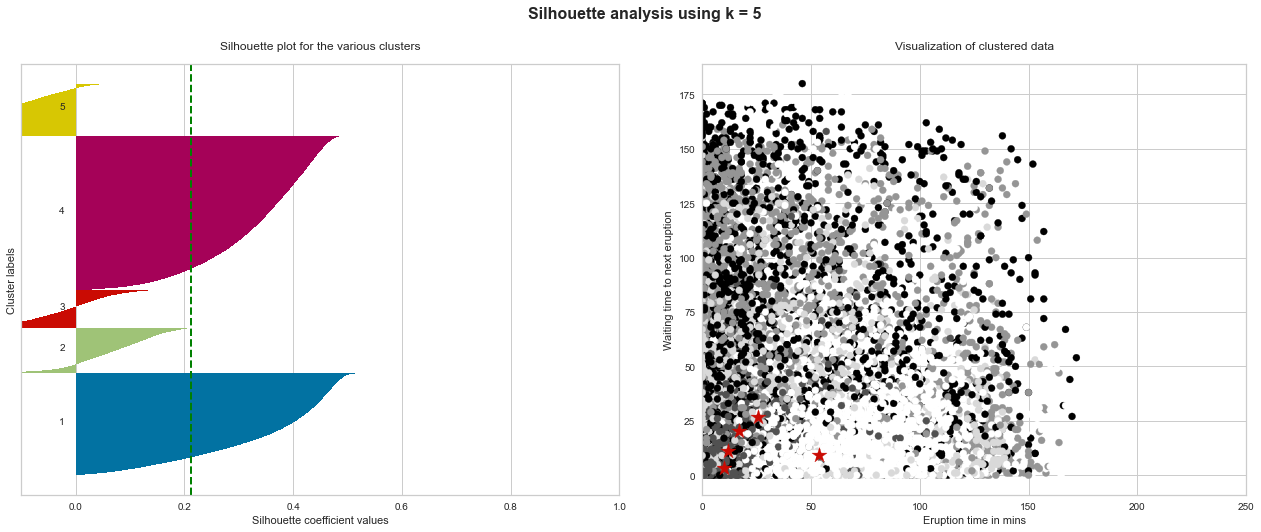

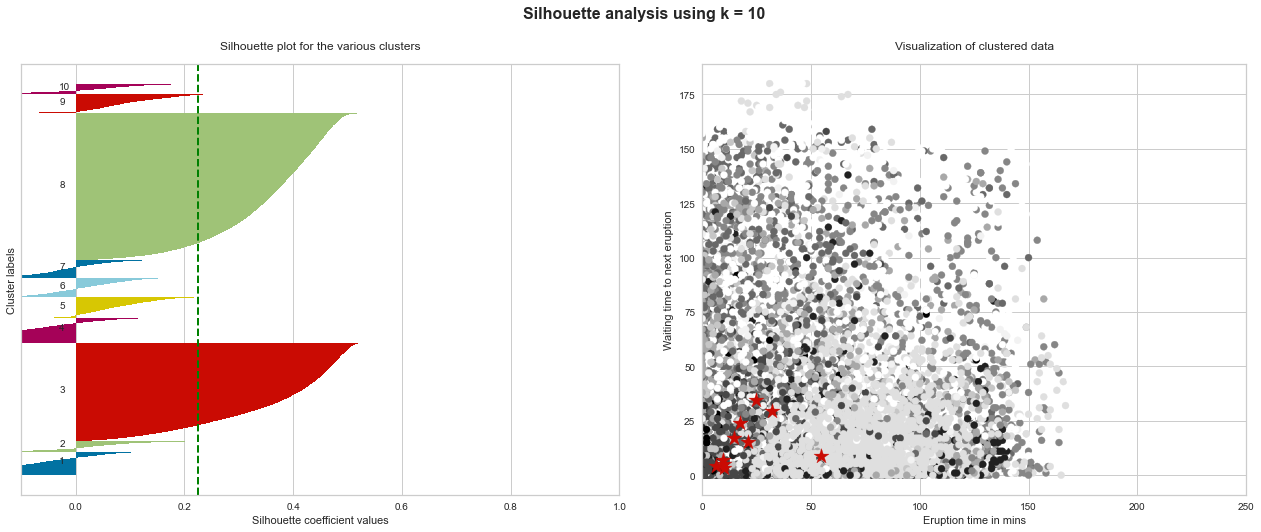

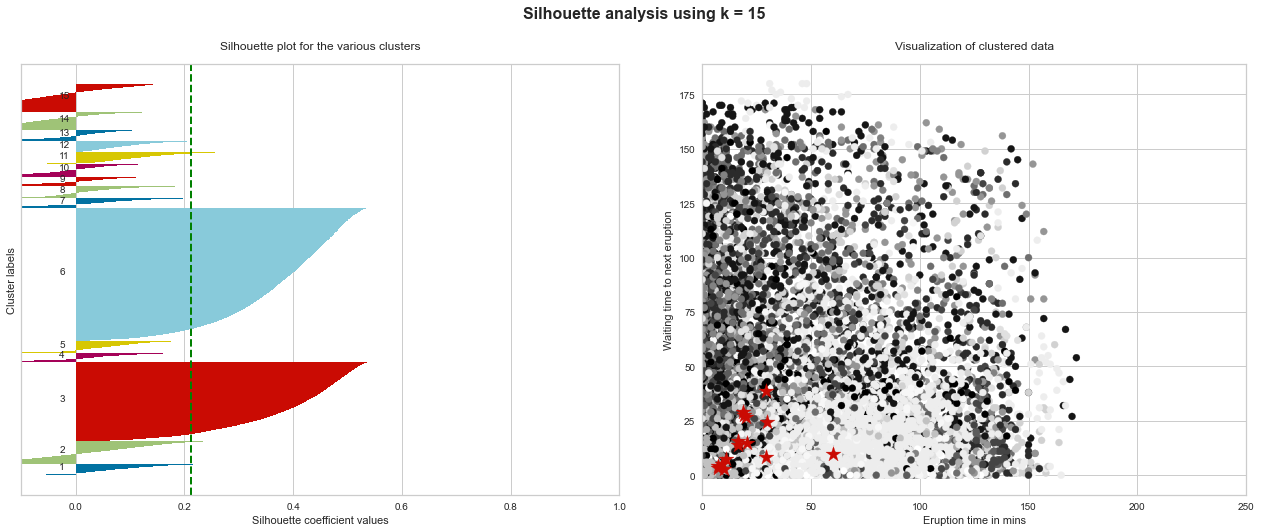

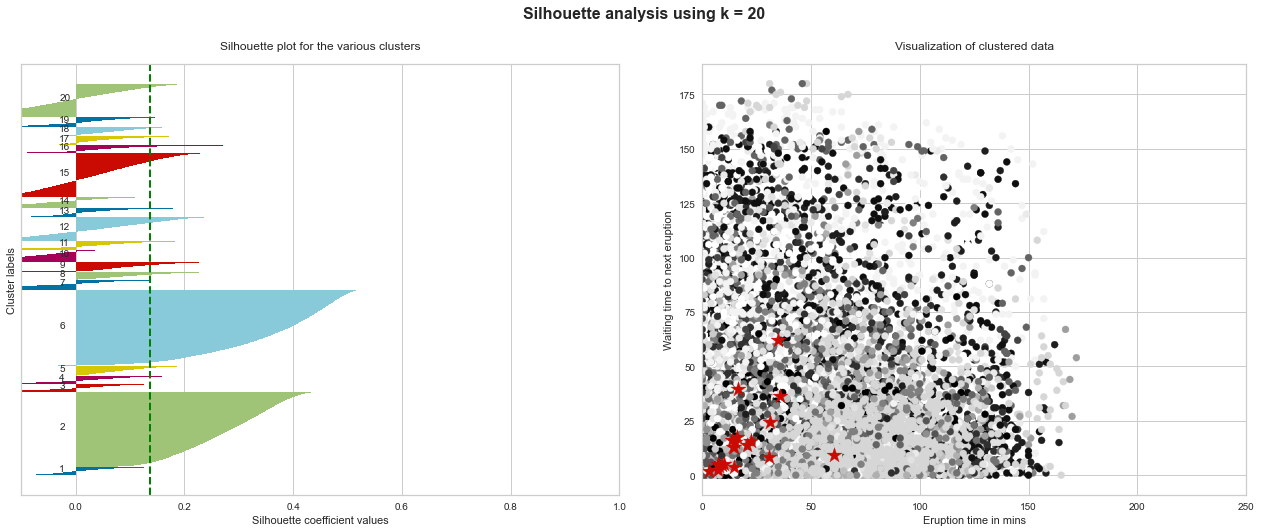

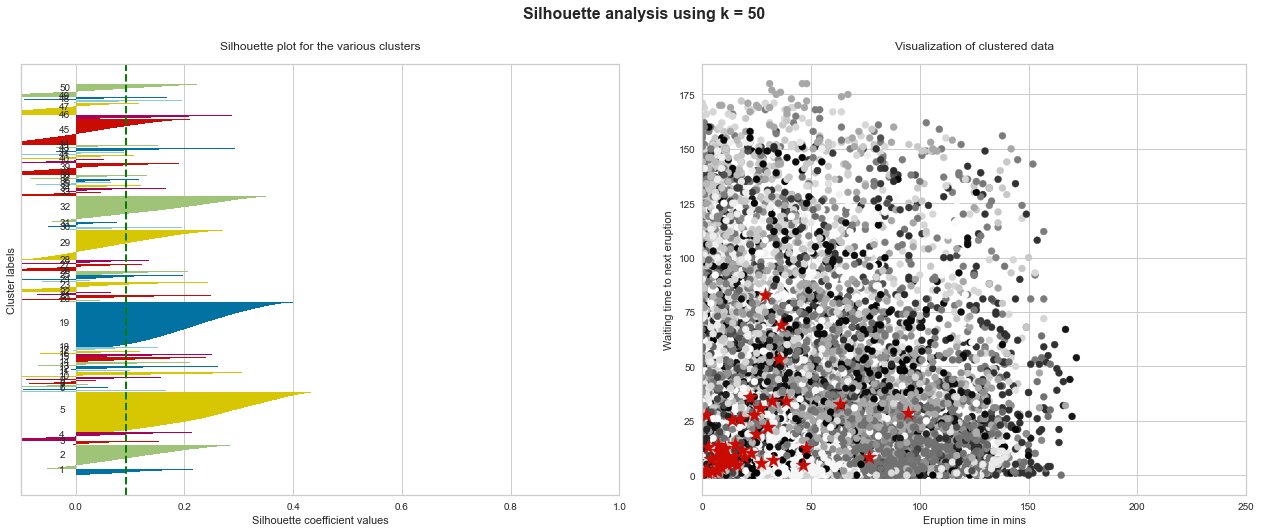

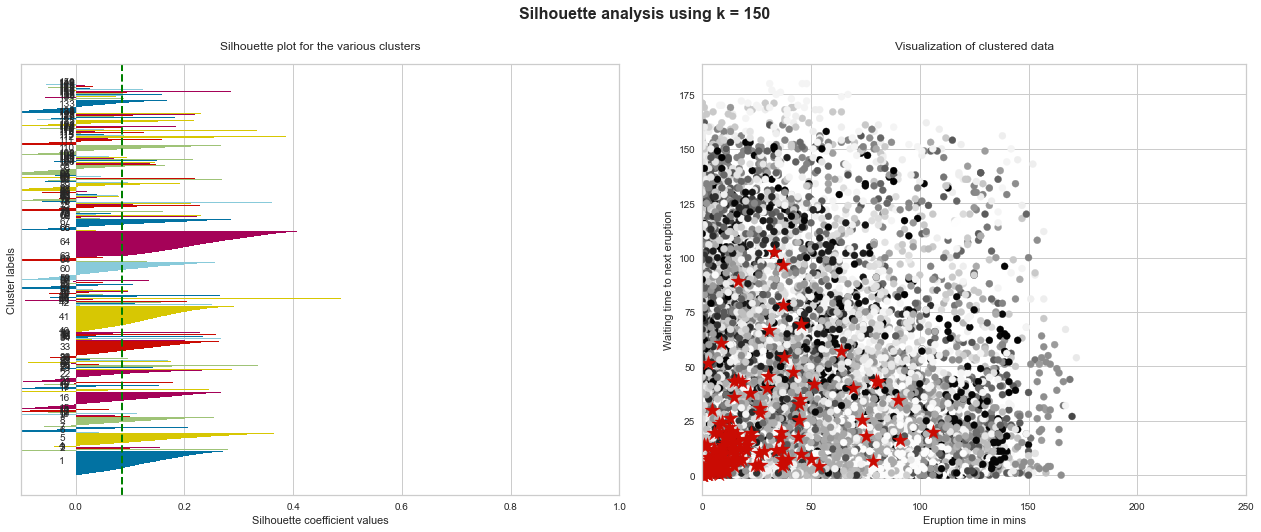

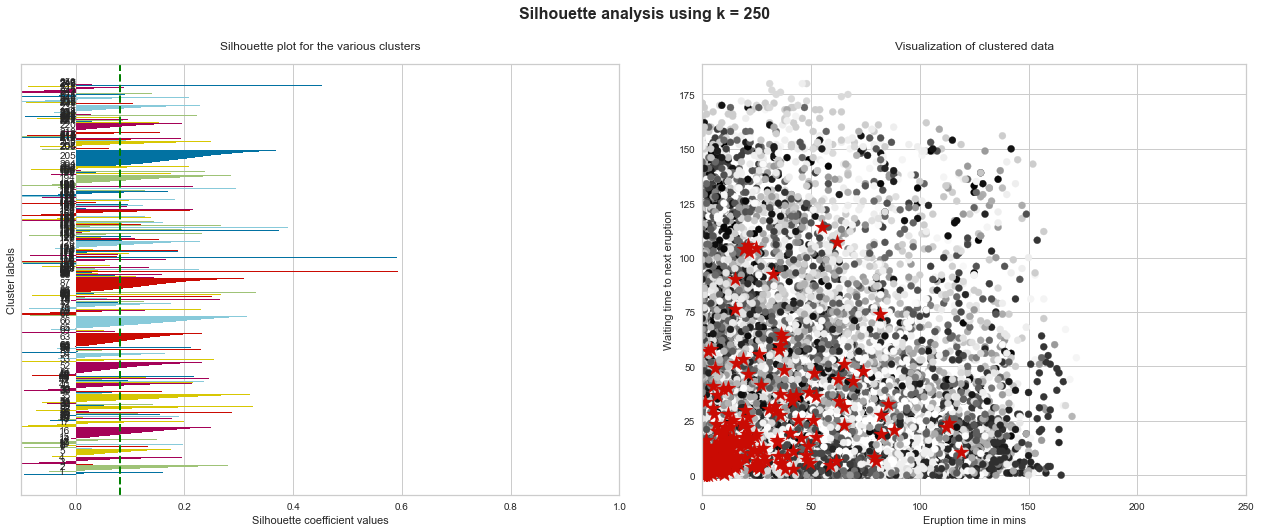

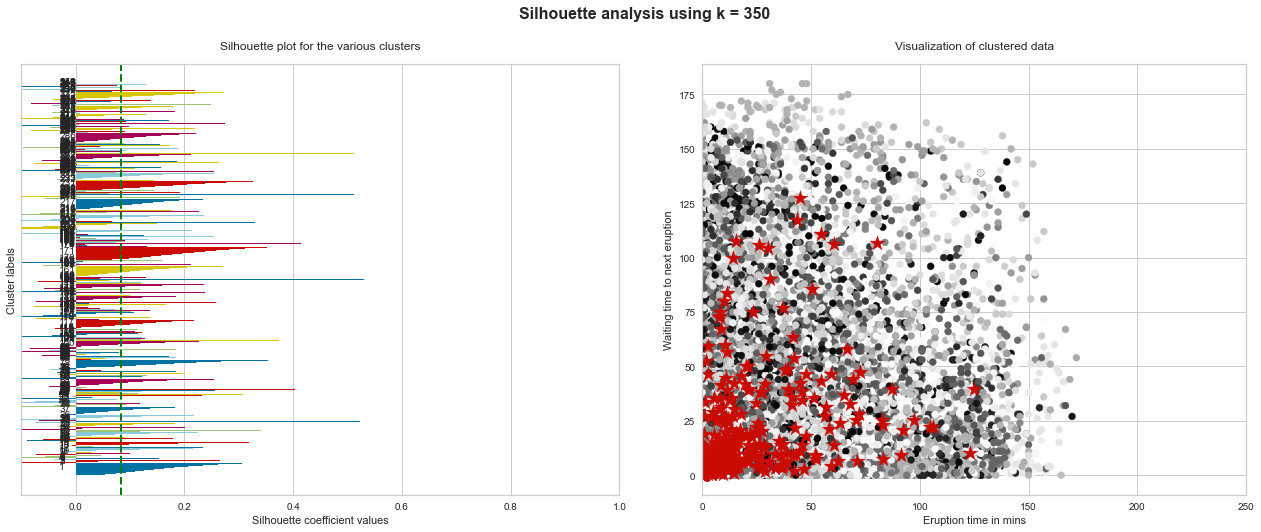

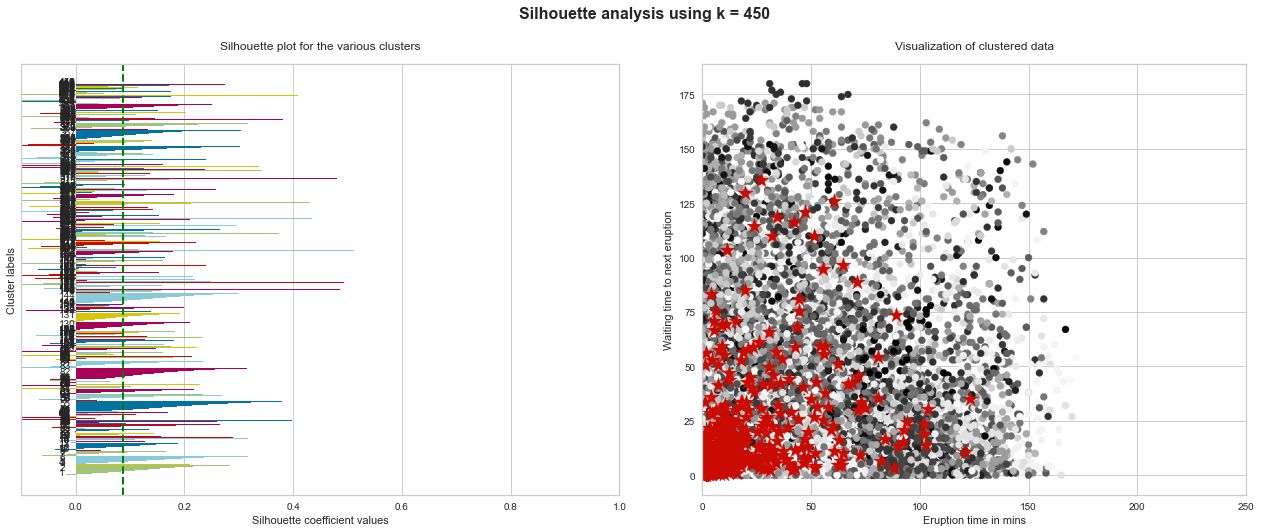

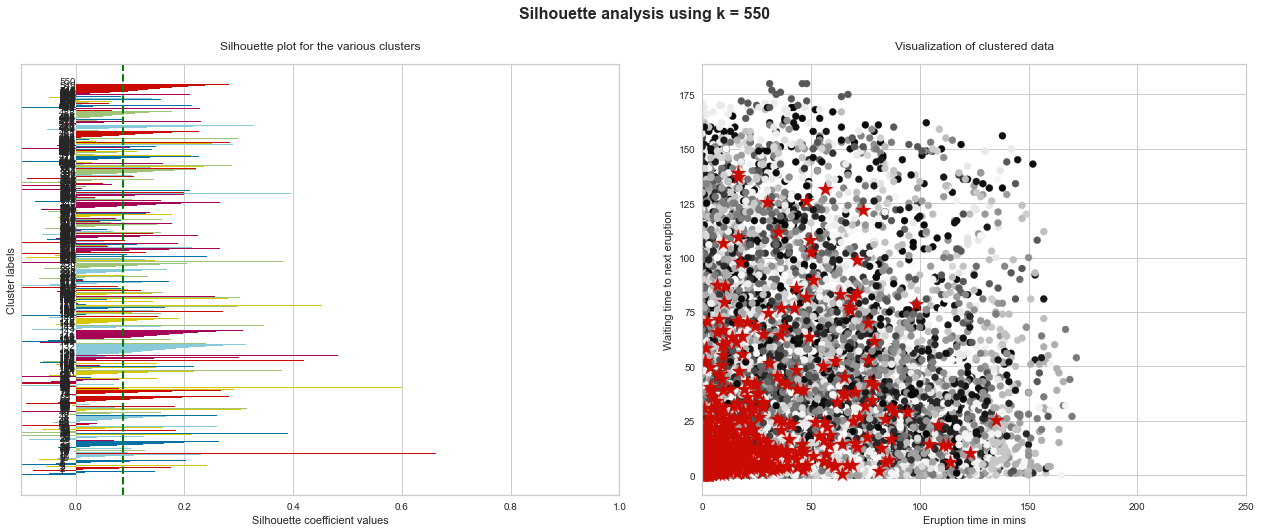

In [8]:
training_data = np.array(training_data)
for i, k in enumerate(list_k):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(training_data)
    centroids = km.cluster_centers_
    sse.append(km.inertia_)


    # Get silhouette samples
    silhouette_vals = silhouette_samples(training_data, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02)
    
    
    ax2.scatter(training_data[:, 0], training_data[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([0, 250])
    ax2.set_xlabel('Eruption time in mins')
    ax2.set_ylabel('Waiting time to next eruption')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);
    silhouette_avg = silhouette_score(training_data, labels)
    print(
        "For n_clusters =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )

Text(0, 0.5, 'Sum of squared distance')

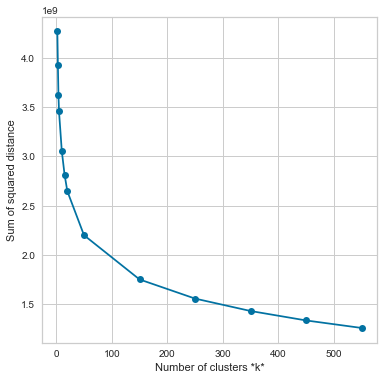

In [9]:
# Plot sse against k, elbow method visualisation
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

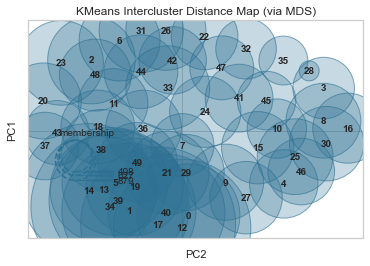

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [31]:
#Intercluster Distance Maps for k = 50 (chosen from elbow method)
num_words = 50

km = KMeans(n_clusters=num_words, random_state=123)
km.fit(training_data)
visualizer = InterclusterDistance(km)

visualizer.fit(training_data)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Based on Elbow method and Silhouette 

In [32]:
dictionary_name = 'fruit'
dictionary = Dictionary(dictionary_name, training_file_names, num_words) #Creating an instance

In [33]:
#Calling function for an object
training_word_histograms = dictionary.learn()

In [34]:
#save dictionary
with open('fruit_dictionary.dic', 'wb') as f: #'wb' is for binary write
    pickle.dump(dictionary, f)

In [35]:
with open('fruit_dictionary.dic', 'rb') as f: #'rb' is for binary read
    dictionary = pickle.load(f)

### 1) KNN

In [36]:
#Measuring accuracy of different number of nearest neighbours

word_histograms = dictionary.create_word_histograms(validation_file_names)
num_nearest_neighbours = [5, 10, 15, 20, 25, 30]

for k in num_nearest_neighbours:
    #Train a model
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(training_word_histograms, training_fruit_labels)

    #Prediction
    predicted_fruit_labels = knn.predict(word_histograms)

    #Evaluation
    num_correct_predictions = np.sum(predicted_fruit_labels == validation_fruit_labels)
    recognition_acc_k = num_correct_predictions/len(validation_fruit_labels)
    print('Neighbours:', k)
    print('Recognition Accuracy:', recognition_acc_k * 100)
    
    #Confusion matrix
    cm = confusion_matrix(validation_fruit_labels, predicted_fruit_labels)
    print('Confusion matrix:')
    print(cm)
    print('----------------------------------------')

Neighbours: 5
Recognition Accuracy: 96.7680608365019
Confusion matrix:
[[159   0   0   0   1]
 [  8 142   1   1   4]
 [  0   0  50   0   0]
 [  0   0   0  78   2]
 [  0   0   0   0  80]]
----------------------------------------
Neighbours: 10
Recognition Accuracy: 97.33840304182509
Confusion matrix:
[[160   0   0   0   0]
 [  7 144   1   2   2]
 [  0   0  50   0   0]
 [  0   0   0  78   2]
 [  0   0   0   0  80]]
----------------------------------------
Neighbours: 15
Recognition Accuracy: 97.14828897338404
Confusion matrix:
[[160   0   0   0   0]
 [  7 143   1   1   4]
 [  0   0  50   0   0]
 [  0   0   0  78   2]
 [  0   0   0   0  80]]
----------------------------------------
Neighbours: 20
Recognition Accuracy: 95.81749049429658
Confusion matrix:
[[160   0   0   0   0]
 [  9 139   1   1   6]
 [  0   0  50   0   0]
 [  0   0   0  76   4]
 [  0   1   0   0  79]]
----------------------------------------
Neighbours: 25
Recognition Accuracy: 95.43726235741445
Confusion matrix:
[[159   1

C:\Users\singh\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\singh\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will

In [43]:
#Final model with k=10
num_nearest_neighbours = 10 #number of neighbours

knn = KNeighborsClassifier(n_neighbors = num_nearest_neighbours)
knn.fit(training_word_histograms, training_fruit_labels)

word_histograms = dictionary.create_word_histograms(testing_file_names)
predicted_fruit_labels = knn.predict(word_histograms)

#Evaluation
num_correct_predictions = np.sum(predicted_fruit_labels == testing_fruit_labels)
recognition_acc = num_correct_predictions/len(testing_fruit_labels)
print('Recognition Accuracy:', recognition_acc * 100)
cm = confusion_matrix(testing_fruit_labels, predicted_fruit_labels)
print('Confusion matrix:')
print(cm)

Recognition Accuracy: 96.1977186311787
Confusion matrix:
[[160   0   0   0   0]
 [ 10 139   0   0   7]
 [  0   0  50   0   0]
 [  0   0   0  77   3]
 [  0   0   0   0  80]]


C:\Users\singh\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### 2) SVC

In [38]:
#Vary C in the range [0.1, 1, 10, 100] and measure the corresponding accuracies. What is the best value for C?

C = [0.1, 1, 10, 100]
word_histograms = dictionary.create_word_histograms(validation_file_names)

for i in C:
    #Train a model
    svm_classifier = svm.SVC(C = i, kernel='linear', random_state=123)
    svm_classifier.fit(training_word_histograms, training_fruit_labels)

    #Prediction
    predicted_fruit_labels = svm_classifier.predict(word_histograms)

    #Evaluation
    num_correct_predictions = np.sum(predicted_fruit_labels == validation_fruit_labels)
    recognition_acc_i = num_correct_predictions/len(validation_fruit_labels)
    print('C:', i)
    print('Recognition Accuracy:', recognition_acc_i * 100)
    
    #Confusion matrix
    cm = confusion_matrix(validation_fruit_labels, predicted_fruit_labels)
    print('Confusion matrix:')
    print(cm)
    print('----------------------------------------')

C: 0.1
Recognition Accuracy: 66.73003802281369
Confusion matrix:
[[158   2   0   0   0]
 [ 24 132   0   0   0]
 [ 50   0   0   0   0]
 [ 16   3   0  61   0]
 [ 40  39   0   1   0]]
----------------------------------------
C: 1
Recognition Accuracy: 95.62737642585552
Confusion matrix:
[[158   2   0   0   0]
 [  9 146   0   1   0]
 [  2   0  48   0   0]
 [  0   0   0  78   2]
 [  1   6   0   0  73]]
----------------------------------------
C: 10
Recognition Accuracy: 98.28897338403041
Confusion matrix:
[[158   2   0   0   0]
 [  4 151   0   1   0]
 [  0   0  50   0   0]
 [  0   0   0  79   1]
 [  0   1   0   0  79]]
----------------------------------------
C: 100
Recognition Accuracy: 98.47908745247148
Confusion matrix:
[[159   1   0   0   0]
 [  5 150   0   1   0]
 [  0   0  50   0   0]
 [  0   0   0  80   0]
 [  0   1   0   0  79]]
----------------------------------------


In [45]:
#Train a model with C=100
svm_classifier = svm.SVC(C = 100, kernel = 'linear', random_state=123)
svm_classifier.fit(training_word_histograms, training_fruit_labels)

word_histograms = dictionary.create_word_histograms(testing_file_names)
predicted_fruit_labels = svm_classifier.predict(word_histograms)

#Evaluation
num_correct_predictions = np.sum(predicted_fruit_labels == testing_fruit_labels)
recognition_acc = num_correct_predictions/len(testing_fruit_labels)
print('Recognition Accuracy:', recognition_acc * 100)

#Confusion matrix
cm = confusion_matrix(testing_fruit_labels, predicted_fruit_labels)
print(cm)

Recognition Accuracy: 97.71863117870723
[[159   0   0   0   1]
 [  9 147   0   0   0]
 [  0   0  50   0   0]
 [  0   0   0  79   1]
 [  0   1   0   0  79]]


### 3) AdaBoost

In [40]:
from sklearn.ensemble import AdaBoostClassifier

#Vary n_estimators in the range [50, 100, 150, 200, 250] and measure accuracies. What is the best value for n_estimators?

n_estimators = [50, 100, 150, 200, 250]
word_histograms = dictionary.create_word_histograms(validation_file_names)

for n in n_estimators:
    #Train a model
    adb_classifier = AdaBoostClassifier(n_estimators = n, random_state = 123)
    adb_classifier.fit(training_word_histograms, training_fruit_labels)

    #Prediction
    predicted_fruit_labels = adb_classifier.predict(word_histograms)

    #Evaluation
    num_correct_predictions = np.sum(predicted_fruit_labels == validation_fruit_labels)
    recognition_acc_n = num_correct_predictions/len(validation_fruit_labels)
    print('N-Estimators:', n)
    print('Recognition Accuracy:', recognition_acc_n * 100)
    
    #Confusion matrix
    cm = confusion_matrix(validation_fruit_labels, predicted_fruit_labels)
    print('Confusion matrix:')
    print(cm)
    print('----------------------------------------')

N-Estimators: 50
Recognition Accuracy: 92.01520912547528
Confusion matrix:
[[142  10   3   0   5]
 [  9 144   0   1   2]
 [  1   2  47   0   0]
 [  1   0   0  76   3]
 [  0   3   2   0  75]]
----------------------------------------
N-Estimators: 100
Recognition Accuracy: 90.68441064638783
Confusion matrix:
[[135  16   5   0   4]
 [  6 146   1   1   2]
 [  0   1  49   0   0]
 [  0   0   0  73   7]
 [  0   2   1   3  74]]
----------------------------------------
N-Estimators: 150
Recognition Accuracy: 90.8745247148289
Confusion matrix:
[[135  16   5   0   4]
 [  6 145   1   2   2]
 [  0   1  49   0   0]
 [  0   0   0  77   3]
 [  0   2   1   5  72]]
----------------------------------------
N-Estimators: 200
Recognition Accuracy: 90.11406844106465
Confusion matrix:
[[135  16   5   0   4]
 [  6 146   1   1   2]
 [  0   1  49   0   0]
 [  0   0   0  72   8]
 [  0   2   1   5  72]]
----------------------------------------
N-Estimators: 250
Recognition Accuracy: 89.92395437262357
Confusion ma

In [44]:
adb_classifier = AdaBoostClassifier(n_estimators = 50, random_state = 123)
adb_classifier.fit(training_word_histograms, training_fruit_labels)

word_histograms = dictionary.create_word_histograms(testing_file_names)
predicted_fruit_labels = adb_classifier.predict(word_histograms)

#Evaluation
num_correct_predictions = np.sum(predicted_fruit_labels == testing_fruit_labels)
recognition_acc = num_correct_predictions/len(testing_fruit_labels)
print('Recognition Accuracy:', recognition_acc * 100)

#Confusion matrix
cm = confusion_matrix(testing_fruit_labels, predicted_fruit_labels)
print(cm)

Recognition Accuracy: 92.39543726235742
[[144  11   0   0   5]
 [ 11 141   1   0   3]
 [  1   3  46   0   0]
 [  0   1   0  76   3]
 [  0   1   0   0  79]]


![Alt Text](https://media.giphy.com/media/H4zC1A2FZ0ViA6GcxD/giphy.gif)